# <font color = "blue">**How To Forecast Time-Series Using Moving-Average Models**

Imagine you're forecasting today's sales.
<br>Today's sales are the average level + today's forecast error + a fraction of yesterday's forecast error + a fraction of the day-before-yesterday's forecast error , and so on (up to q days).
$$y_t = \mu + ϵ_t + \theta_1ϵ_{t-1} + \theta_2ϵ_{t-2} .... + \theta_qϵ_{t-q}$$
where
* $y_t$ → value at time t
* $\mu$→ mean of the series
* $ϵ_t$ → forecast error at time t
* $\theta_1, \theta_2$, ... → coefficients telling how past shocks affect today.

The order q tells how many past errors are used.

#### Let's say we have an MA(1) model:
$$y_t = 100 + ϵ_t + 0.5ϵ_{t-1}$$
* If yesterday's error (εₜ₋₁) was +20 (we underpredicted by 20),
today's forecast will be pulled up by 0.5 x 20 = 10 units.
* If yesterday's error was -10 (we overpredicted by 10),
today's forecast will drop by 0.5 x -10 = -5 units.

### Assumptions
#### **Stationarity**
The time series should be weakly stationary — meaning:
* Mean is constant over time
* Variance is constant over time
* Autocovariance depends only on lag, not on the actual time

#### **White Noise Errors**
The error terms $𝜀_t$ should be:
* Independent (no autocorrelation between them)
* Normally distributed (for inference)
* Mean = 0
* Constant variance $𝜎^2$

#### **Linearity in Errors**
The model is linear in terms of the error terms:
$$y_t = \mu + ϵ_t + \theta_1ϵ_{t-1} + \theta_2ϵ_{t-2} .... + \theta_qϵ_{t-q}$$
The relationship between current value and past shocks is additive and proportional.

####  **Invertibility**
The MA model should be invertible —
meaning it can be represented as an infinite-order AR model. This ensures:
* Unique parameter estimates
* Stability of the model

**Invertibility condition**: The roots of the MA characteristic equation must lie outside the unit circle.



### <font color = "green">**When to use MA model**

In [ ]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

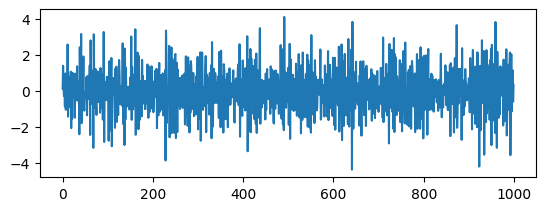

In [ ]:
# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

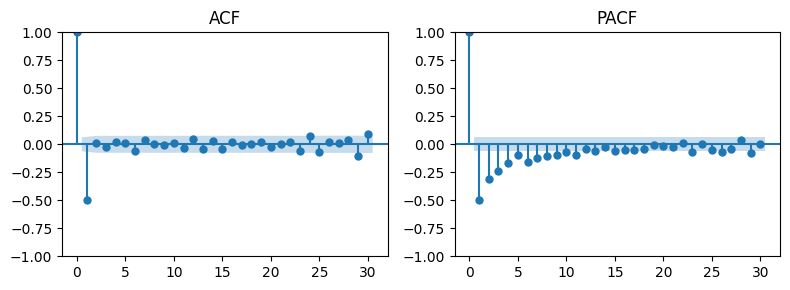

In [ ]:
# Create subplots side by side with smaller figure size
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot ACF
plot_acf(simulated_data_1, lags=30, ax=axes[0])
axes[0].set_title("ACF")

# Plot PACF
plot_pacf(simulated_data_1, lags=30, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

#### The Two Plots
* **ACF (Autocorrelation Function)**
<br>Shows how yₜ is related to $y_{t-k}$ for different lags k.
<br>Think of it as: *How much today is similar to values k steps back?*

* **PACF (Partial Autocorrelation Function)**
<br>Shows how yₜ is related to yₜ₋ₖ after removing the effect of the in-between lags.
<br>Think of it as: *What’s the direct relationship between today and k steps back?*

If your series is best described by MA(q), you’ll usually see:
* ACF: Sharp cut-off after lag q (values after q are near zero)
* PACF: Gradual decay (tails off slowly).

The ACF of this series cut-off after lag 1. Hence this series is perfect for MA model of order 1 (becase series cut-off after lag 1).



### <font color = "green">**Parameter Estimation**
Now that we have our order of MA terms, we need to fit their coefficients! Unfortunately, this is not as easy as in linear or autoregression as the errors are not observable. So, how do we do it?

Well, it is not so straightforward. However, the general gist is that the autocorrelation values for each lag are directly related to their coefficients. Therefore, once you know the autocorrelation of a forecast error, you can work backwards to acquire its coefficient.

For example, for a MA(1) model (model with one forecast error term), its autocorrelation, $c_1$, is
$$c_1 = \frac{\theta_1}{1+\theta_1^2}$$
One can see that if we know $c_1$, then this is just a simple quadratic equation that we can solve for the coefficient. This same idea can be extended to a MA(q) model, but with more complexity of course due to multiple errors and coefficients.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Import packages
import plotly.express as px
import pandas as pd

In [ ]:
# Read in the data
data = pd.read_csv('/content/drive/MyDrive/Learning Repo/Time Series Forecasting (1)/data/AirPassengers (1).csv')
data['Month'] = pd.to_datetime(data['Month'])


def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Month', y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Airline Passengers',
                      width=650, title_x=0.5, height=400)

    return fig.show()


# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

The time series has a clear trend and obvious yearly seasonality that is increasing through time. Therefore, we need to make it stationary by carrying out differencing and applying the Box-Cox transform:

In [ ]:
# Import packages
from scipy.stats import boxcox

# Make the target stationary
data['Passengers_boxcox'], lam = boxcox(data['#Passengers'])
data["Passenger_stationary"] = data["Passengers_boxcox"].diff()
data.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_passenger_volumes(df=data, y='Passenger_stationary')

The data now appears to be stationary. We could have made it further stationary by carrying out second order differencing or seasonal differencing, however I think it is satisfactory here.

### **Modelling**
We can now start the modelling phase by finding the optimal number of orders. To do this, we plot an autocorrelation correlogram like we discussed above:

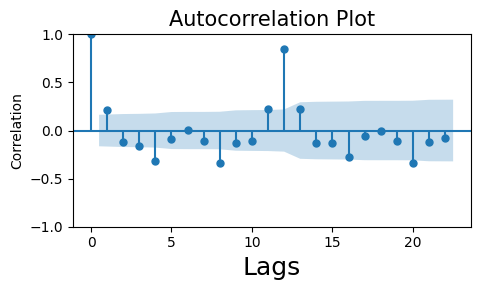

In [ ]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation
plt.rc("figure", figsize=(5,3))
plot_acf(data['Passenger_stationary'])
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Autocorrelation Plot', fontsize=15)
plt.tight_layout()
plt.show()

The blue region signifies where the values are no longer statistically significant. From the above plot, we can that see that the last significant lag is the 13th. Therefore, our model order for the MA model will be 13. Unfortunately, no direct MA model function or package exists in Python, so we are going to use the ARIMA function from statsmodels and set every component to zero apart from the moving average orders.

In [ ]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Train model
model = ARIMA(train['Passenger_stationary'], order=(0, 0, 13)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:60

### **Results**
The forecasts produced from this fitted model is for the differenced and Box-Cox transformed time series that we produced earlier. Therefore, we have to un-difference and apply the inverse Box-Cox transform to the predictions to acquire the actual airline passenger forecasted volumes:

In [ ]:
# Import packages
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Moving Average Model')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



We can see the forecasts have captured the trend mostly well, however they have failed to notice the seasonality. In my previous article, the autoregression model, that was trained on the same data, managed to pick up both the trend and seasonality.